In [1]:
using Pkg.TOML

using Random: seed!
using Revise
using RMMMDNets

# enable_gpu()
# disable_gpu()

;

┌ Info: Recompiling stale cache file /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/compiled/v1.2/RMMMDNets/mJmbq.ji for RMMMDNets [7ea7fd3b-14e3-4223-94d2-c341911ad28e]
└ @ Base loading.jl:1240


In [2]:
rmmmdnets_path = pathof(RMMMDNets) |> splitdir |> first |> splitdir |> first
hyper = TOML.parsefile("$rmmmdnets_path/examples/Hyper.toml")

# dataset = "gaussian"
# dataset = "ring"
dataset = "mnist"
# model_name = "gan"
# model_name = "mmdnet"
model_name = "rmmmdnet"

args_dict = parse_toml(hyper, dataset, model_name)
args = parse_args_dict(args_dict; override=(seed=1, lr=1f-3, Df_h="conv", sigma="0.1,1,10,100",))

###

data = get_data(dataset)

;

┌ Warning: The values for key :seed in `args_dict` and `override` are the same: 1.
└ @ RMMMDNets /afs/inf.ed.ac.uk/user/s16/s1672897/projects/RMMMDNets.jl/src/RMMMDNets.jl:36
┌ Info: Args
│   batch_size_gen = 200
│   batch_size = 200
│   Df_h = conv
│   act = relu
│   Dg_h = 600,600,800
│   D_fx = 100
│   D_z = 100
│   dataset = mnist
│   act_last = sigmoid
│   sigma = 0.1,1,10,100
│   opt = adam
│   model_name = rmmmdnet
│   norm = true
│   n_epochs = 20
│   beta1 = 0.5
│   base = uniform
│   lr = 0.001
│   seed = 1
└ @ RMMMDNets /afs/inf.ed.ac.uk/user/s16/s1672897/projects/RMMMDNets.jl/src/RMMMDNets.jl:41


In [ ]:
function run_exp(args)    
    seed!(args.seed)

    model = get_model(args, data)
    evaluate(data, model)

    dataloader = DataLoader(data, args.batch_size)
    
    train!(model, args.n_epochs, dataloader)
    evaluate(data, model)
    
    model_fname = save!(model)
    
    return model, model_fname
end

model_trained, model_trained_fname = run_exp(args)

;

Test `load!`

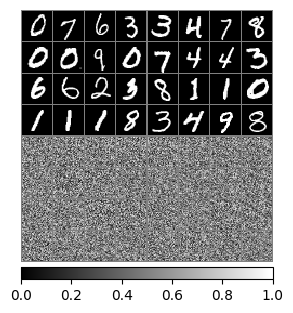

┌ Info: Init rmmmdnet with 1,577,092 parameters
│   logdir = mnist/rmmmdnet/batch_size_gen=200-batch_size=200-Df_h=conv-act=relu-Dg_h=600,600,800-D_fx=100-D_z=100-sigma=0.1,1,10,100-opt=adam-norm=true-beta1=0.5-base=uniform-lr=0.0005-seed=1/24092019-14-13-45
└ @ RMMMDNets /afs/inf.ed.ac.uk/user/s16/s1672897/projects/RMMMDNets.jl/src/RMMMDNets.jl:164


In [10]:
model = get_model(args, data)
evaluate(data, model)

;

In [ ]:
"mnist/rmmmdnet/batch_size_gen=200-batch_size=200-Df_h=400,200-act=relu-Dg_h=conv-D_fx=100-D_z=100-sigma=0.1,1,10,100-opt=adam-norm=true-beta1=0.5-base=uniform-lr=0.0005-seed=1/24092019-5-20-13"

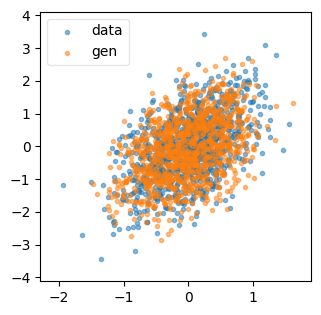

┌ Info: Loaded model at 250 iterations from /afs/inf.ed.ac.uk/group/cup/data1/kai/logs/rmmmdnets/gaussian/mmdnet/opt=rmsprop-batch_size_gen=200-batch_size=200-act=tanh-Dg_h=50,50-sigma=1,2-base=uniform-lr=0.001-D_z=10-seed=1/23092019-16-35-58/model.bson
└ @ RMMMDNets /afs/inf.ed.ac.uk/user/s16/s1672897/projects/RMMMDNets.jl/src/RMMMDNets.jl:188


In [5]:
load!(model, model_trained_fname)
evaluate(data, model)

;